## Problem Statement

The goal is to improve detection of staged auto accident fraud in standard auto insurance claims by developing a machine learning model that can flag high-risk claims, increasing detection accuracy by at least 25% within 12 months.

## Project Objective

- Reduce financial loss caused by fraudulent claims.
- Enable faster and more accurate identification of suspicious claims.
- Support claims investigators with data-driven fraud risk scoring.

## Key Performance Indicators (KPIs)

These are the metrics we used to evaluate our model’s impact:

- Precision - How many of the flagged claims are actually fraud. Important to avoid false accusations.
- Recall - How many frauds you’re catching out of total frauds. Important to not miss cases.
- F1-Score - Balance between precision and recall.
- False Positive Rate - Keeps investigation workload low.
- Estimated $ Saved - Based on average fraudulent claim cost × number of frauds detected.

## Fraud Triangle Framework

This project is grounded in the Fraud Triangle Theory, which explains fraudulent behavior as arising from:

- Pressure (financial strain or motivation)
- Opportunity (weaknesses in detection systems)
- Rationalization (justifying the act)

Our data and model features directly reflect these dimensions, allowing us to detect suspicious claims based on both behavioral and contextual signals.

In [124]:
import pandas as pd

claims = pd.read_csv('Claims.csv')
policyholders = pd.read_csv('Policyholders.csv')
vendors = pd.read_csv('Vendors.csv')
enhanced = pd.read_csv('Fraudulent_Claims_Detection_Enhancement.csv')
segments = pd.read_csv('normalised_dataframe_segments.csv')

In [125]:
# Check dimensions and preview the first few rows
print("Claims:", claims.shape)
print("Policyholders:", policyholders.shape)
print("Vendors:", vendors.shape)
print("Enhanced Features:", enhanced.shape)
print("Segments:", segments.shape)

claims.head()

Claims: (99994, 22)
Policyholders: (99994, 11)
Vendors: (99994, 3)
Enhanced Features: (99994, 31)
Segments: (99994, 1)


,Fraudulent_Claim_Flag,Claim_ID,Accident_Timestamp,Accident_Latitude,Accident_Longitude,Accident_Altitude,Collision_Angle,Vehicle_Speed,Repair_Cost_Estimate,Labor_Cost_Estimate,...,Claim_Submission_Timestamp,Submission_Delay,Duplicate_Claim_Flag,External_Benchmark_Repair_Cost,Cost_Ratio,Adjusted_Damage_Severity,Similar_Claims_Count,Vendor_ID,Policyholder_ID,axio_segment_number
0,False,33301545,2023-01-11 00:00:00,-39.37,133.32,3843.40,109.26,95.45,4955.38,1185.46,...,2023-01-12 00:00:00,112.55,False,12754.82,0.390,Medium,13,21413448,52051275,0
1,False,46137049,2023-09-02 00:00:00,-20.60,-75.99,571.34,206.54,88.35,8739.73,1796.27,...,2023-09-03 00:00:00,12.60,False,2566.09,3.410,Medium,19,21413448,35765864,0
2,False,9701653,2023-07-04 00:00:00,-29.81,173.48,-352.83,135.13,151.20,533.32,4282.49,...,2023-07-22 00:00:00,344.85,False,15248.24,0.035,Low,20,21413448,35765864,0
3,False,88059915,2023-09-08 00:00:00,-2.14,-52.58,2996.93,109.12,74.28,7458.18,308.21,...,2023-09-13 00:00:00,74.16,False,10538.14,0.710,Medium,20,21413448,35765864,0
4,False,32598428,2023-10-23 00:00:00,-88.16,172.31,916.77,56.34,57.82,10473.96,1362.67,...,2023-10-28 00:00:00,128.25,False,1975.36,5.300,Medium,28,21413448,35765864,0


In [126]:
# Claims
print("Claims")
claims.info()
print(claims.isnull().sum())

# Policyholders
print("\n Policyholders")
policyholders.info()
print(policyholders.isnull().sum())

# Vendors
print("\n Vendors")
vendors.info()
print(vendors.isnull().sum())

# Enhanced
print("\n Enhanced Features")
enhanced.info()
print(enhanced.isnull().sum())

# Segments
print("\n Segments")
segments.info()
print(segments.isnull().sum())

Claims
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99994 entries, 0 to 99993
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Fraudulent_Claim_Flag           99994 non-null  bool   
 1   Claim_ID                        99994 non-null  int64  
 2   Accident_Timestamp              99994 non-null  object 
 3   Accident_Latitude               99994 non-null  float64
 4   Accident_Longitude              99994 non-null  float64
 5   Accident_Altitude               99994 non-null  float64
 6   Collision_Angle                 99994 non-null  float64
 7   Vehicle_Speed                   99994 non-null  float64
 8   Repair_Cost_Estimate            99994 non-null  float64
 9   Labor_Cost_Estimate             99994 non-null  float64
 10  Parts_Cost_Estimate             99994 non-null  float64
 11  Reported_Damage_Severity        99994 non-null  object 
 12  Claim_Submission_Timestam

In [127]:
print("Unique Claim_IDs in claims:", claims['Claim_ID'].is_unique)
print("Unique Policyholder_IDs:", policyholders['Policyholder_ID'].is_unique)
print("Unique Vendor_IDs:", vendors['Vendor_ID'].is_unique)

Unique Claim_IDs in claims: True
Unique Policyholder_IDs: True
Unique Vendor_IDs: True


| Dataset | Description | Key Column(s) | Shape (Rows, Cols) | Notes |
|---------|-------------|----------------|----------------------|--------|
| Claims | Core claim-level info, timestamps, amounts, fraud flag | Claim_ID, Policyholder_ID, Vendor_ID | (99994, 22) | Main dataset; includes event-level claim data and fraud labels |
| Policyholders | Customer demographics and history | Policyholder_ID | (99994, 11) | One row per customer; demographic and historical claim data |
| Vendors | Vendor details, average costs | Vendor_ID | (99994, 3) | Vendor-level info; joins with Claims via Vendor_ID to assess repair cost behavior |
| Enhanced | Engineered fraud features | Claim_ID | (99994, 31) | Rich set of engineered fraud-related features; enhances predictive power |
| Segments | Risk segment names based on rules | Claim_ID | (99994, 1) | Contains fraud risk segments derived from business rules; supports model explainability |


In [128]:
#checking where missing values are and decide what to do
print("Missing values in each dataset before merge:")
print("Claims:\n", claims.isnull().sum())
print("Policyholders:\n", policyholders.isnull().sum())
print("Vendors:\n", vendors.isnull().sum())
print("Enhanced:\n", enhanced.isnull().sum())
print("Segments:\n", segments.isnull().sum())

Missing values in each dataset before merge:
Claims:
 Fraudulent_Claim_Flag             0
Claim_ID                          0
Accident_Timestamp                0
Accident_Latitude                 0
Accident_Longitude                0
Accident_Altitude                 0
Collision_Angle                   0
Vehicle_Speed                     0
Repair_Cost_Estimate              0
Labor_Cost_Estimate               0
Parts_Cost_Estimate               0
Reported_Damage_Severity          0
Claim_Submission_Timestamp        0
Submission_Delay                  0
Duplicate_Claim_Flag              0
External_Benchmark_Repair_Cost    0
Cost_Ratio                        0
Adjusted_Damage_Severity          0
Similar_Claims_Count              0
Vendor_ID                         0
Policyholder_ID                   0
axio_segment_number               0
dtype: int64
Policyholders:
 Policyholder_ID                   0
Policy_Coverage_Type              0
Historical_Claim_Frequency        0
Historical_Avg_Cl

In [129]:
# Replace missing Employment Status with 'Unknown'
policyholders['Policyholder_Employment_Status'] = policyholders['Policyholder_Employment_Status'].fillna('Unknown')

# Replace missing Submission_Delay with the median
if 'Submission_Delay' in claims.columns:
    claims['Submission_Delay'] = claims['Submission_Delay'].fillna(claims['Submission_Delay'].median())

In [130]:
# Convert accident and submission timestamps to datetime objects
claims['Accident_Timestamp'] = pd.to_datetime(claims['Accident_Timestamp'])
claims['Claim_Submission_Timestamp'] = pd.to_datetime(claims['Claim_Submission_Timestamp'])

In [131]:
# Reset index to expose Claim_ID if it's currently the index
segments.reset_index(inplace=True)

# Rename columns for consistent merging
segments.rename(columns={
    'index': 'Claim_ID',
    'axio_segment_number': 'Segment_Name'
}, inplace=True)

# Make sure all Claim_IDs are the same type across datasets
claims['Claim_ID'] = claims['Claim_ID'].astype(str)
segments['Claim_ID'] = segments['Claim_ID'].astype(str)
enhanced['Claim_ID'] = enhanced['Claim_ID'].astype(str)

In [132]:
# Merge all relevant dataframes into one master dataframe
df = claims.merge(policyholders, on='Policyholder_ID', how='left') \
           .merge(vendors, on='Vendor_ID', how='left') \
           .merge(enhanced, on='Claim_ID', how='left') \
           .merge(segments[['Claim_ID', 'Segment_Name']], on='Claim_ID', how='left')

In [133]:
# Label all unmatched claims with 'Unsegmented'
df['Segment_Name'] = df['Segment_Name'].fillna('Unsegmented')

In [134]:
# Print shape and missing segment count for verification
print("Final merged dataset shape:", df.shape)
print("Missing Segment Names:", df['Segment_Name'].isnull().sum())

# Preview a few rows
df.head()

Final merged dataset shape: (99994, 65)
Missing Segment Names: 0


,Fraudulent_Claim_Flag_x,Claim_ID,Accident_Timestamp_x,Accident_Latitude_x,Accident_Longitude_x,Accident_Altitude_x,Collision_Angle_x,Vehicle_Speed_x,Repair_Cost_Estimate_x,Labor_Cost_Estimate_x,...,Vendor_Avg_Repair_Cost_y,Accident_Timestamp_y,Vendor_ID_y,Labor_Cost_Estimate_y,Historical_Avg_Claim_Cost_y,Policy_Coverage_Type_y,Parts_Cost_Estimate_y,Policyholder_Employment_Status_y,Claim_Submission_Timestamp_y,Segment_Name
0,False,33301545,2023-01-11,-39.37,133.32,3843.40,109.26,95.45,4955.38,1185.46,...,11321.533138,2023-01-11 00:00:00,21413448,1185.46,10271.43,Collision,1549.70,Retired,2023-01-12 00:00:00,Unsegmented
1,False,46137049,2023-09-02,-20.60,-75.99,571.34,206.54,88.35,8739.73,1796.27,...,11321.533138,2023-09-02 00:00:00,21413448,1796.27,18337.95,Collision,9905.31,Employed,2023-09-03 00:00:00,Unsegmented
2,False,9701653,2023-07-04,-29.81,173.48,-352.83,135.13,151.20,533.32,4282.49,...,11321.533138,2023-07-04 00:00:00,21413448,4282.49,18337.95,Collision,6901.05,Employed,2023-07-22 00:00:00,Unsegmented
3,False,88059915,2023-09-08,-2.14,-52.58,2996.93,109.12,74.28,7458.18,308.21,...,11321.533138,2023-09-08 00:00:00,21413448,308.21,18337.95,Collision,3943.90,Employed,2023-09-13 00:00:00,Unsegmented
4,False,32598428,2023-10-23,-88.16,172.31,916.77,56.34,57.82,10473.96,1362.67,...,11321.533138,2023-10-23 00:00:00,21413448,1362.67,18337.95,Collision,43.71,Employed,2023-10-28 00:00:00,Unsegmented


In [135]:
# Save final merged dataset for use in modeling
df.to_csv("merged_fraud_dataset.csv", index=False)
df.to_pickle("merged_fraud_dataset.pkl")  # faster loading later

## Risk Segmentation Rules (From PDF)

The following business rules define how claims are segmented based on risk:

| Business Rule                                                   | Risk Level  |
|------------------------------------------------------------------|-------------|
| Claim Amount > $22,000 and Submission Delay < 12 hours          | High Risk   |
| License Age > 55 years and Claim Amount is within normal range  | Low Risk    |

In [136]:
print(df.columns.tolist())

['Fraudulent_Claim_Flag_x', 'Claim_ID', 'Accident_Timestamp_x', 'Accident_Latitude_x', 'Accident_Longitude_x', 'Accident_Altitude_x', 'Collision_Angle_x', 'Vehicle_Speed_x', 'Repair_Cost_Estimate_x', 'Labor_Cost_Estimate_x', 'Parts_Cost_Estimate_x', 'Reported_Damage_Severity_x', 'Claim_Submission_Timestamp_x', 'Submission_Delay_x', 'Duplicate_Claim_Flag_x', 'External_Benchmark_Repair_Cost_x', 'Cost_Ratio_x', 'Adjusted_Damage_Severity_x', 'Similar_Claims_Count_x', 'Vendor_ID_x', 'Policyholder_ID_x', 'axio_segment_number_x', 'Policy_Coverage_Type_x', 'Historical_Claim_Frequency_x', 'Historical_Avg_Claim_Cost_x', 'Denied_Claims_History_x', 'Policyholder_Age_x', 'Policyholder_Gender_x', 'Policyholder_Income_x', 'Policyholder_Employment_Status_x', 'Policyholder_License_Age_x', 'axio_segment_number_y', 'Vendor_Avg_Repair_Cost_x', 'axio_segment_number', 'Policyholder_Age_y', 'Policyholder_Gender_y', 'Similar_Claims_Count_y', 'Fraudulent_Claim_Flag_y', 'Historical_Claim_Frequency_y', 'Accident

In [137]:
df['Custom_Segment'] = 'Unsegmented'

# High Risk: Large claim + fast submission
df.loc[
    (df['Historical_Avg_Claim_Cost_x'] > 22000) & (df['Submission_Delay_x'] < 12),
    'Custom_Segment'
] = 'High Risk'

# Low Risk: Older driver + modest claim
df.loc[
    (df['Policyholder_Age_x'] > 55) & (df['Historical_Avg_Claim_Cost_x'] <= 22000),
    'Custom_Segment'
] = 'Low Risk'

# Everyone else
df.loc[
    df['Custom_Segment'] == 'Unsegmented',
    'Custom_Segment'
] = 'Medium Risk'

In [138]:
# Segment distribution
print(df['Custom_Segment'].value_counts())

# Fraud rate by segment
df.groupby('Custom_Segment')['Fraudulent_Claim_Flag_x'].mean().sort_values(ascending=False)

Custom_Segment
Medium Risk    53593
Low Risk       46201
High Risk        200
Name: count, dtype: int64


,Fraudulent_Claim_Flag_x
Custom_Segment,
High Risk,0.830000
Medium Risk,0.291549
Low Risk,0.098136


In [140]:
segment_stats = df.groupby('Custom_Segment').agg({
    'Fraudulent_Claim_Flag_x': 'mean',
    'Claim_ID': 'count'
}).rename(columns={
    'Fraudulent_Claim_Flag_x': 'Fraud Rate',
    'Claim_ID': 'Claim Volume'
}).sort_values(by='Fraud Rate', ascending=False)

<ipython-input-141-910dd6e7d576>:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




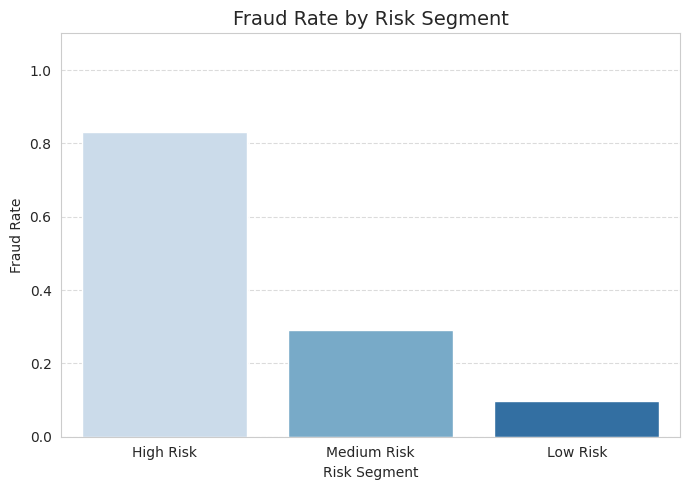

In [141]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set style
sns.set_style("whitegrid")

# Generate consistent blue shades manually
colors = sns.color_palette("Blues", n_colors=len(segment_stats))

# Plot
plt.figure(figsize=(7, 5))
sns.barplot(x=segment_stats.index, y=segment_stats['Fraud Rate'], palette=colors)
plt.title("Fraud Rate by Risk Segment", fontsize=14)
plt.ylabel("Fraud Rate")
plt.xlabel("Risk Segment")
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<ipython-input-142-f96221350210>:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




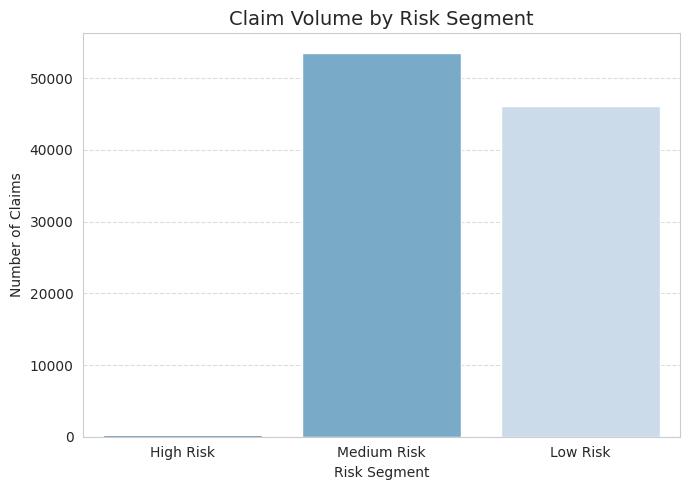

In [142]:
# Claim Volume by Risk Segment
# Generate reversed blue palette manually
rev_colors = sns.color_palette("Blues_r", n_colors=len(segment_stats))

# Plot
plt.figure(figsize=(7, 5))
sns.barplot(x=segment_stats.index, y=segment_stats['Claim Volume'], palette=rev_colors)
plt.title("Claim Volume by Risk Segment", fontsize=14)
plt.ylabel("Number of Claims")
plt.xlabel("Risk Segment")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Added Percentange to risk segments

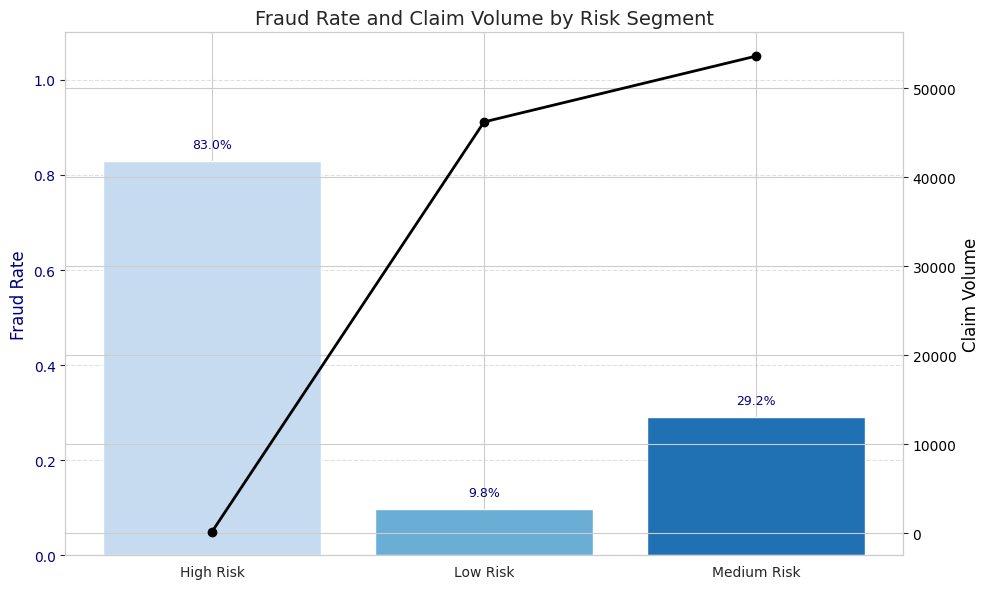

In [143]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort the index for consistent order
segment_stats = segment_stats.sort_index()
sns.set_style("whitegrid")

fig, ax1 = plt.subplots(figsize=(10, 6))
colors = sns.color_palette("Blues", n_colors=len(segment_stats))

# Bar chart for Fraud Rate
bars = ax1.bar(segment_stats.index, segment_stats['Fraud Rate'], color=colors)
ax1.set_ylabel("Fraud Rate", color='navy', fontsize=12)
ax1.tick_params(axis='y', labelcolor='navy')
ax1.set_ylim(0, 1.1)

# ➕ Add % labels
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + 0.02, f'{height*100:.1f}%',
             ha='center', va='bottom', fontsize=9, color='navy')

# Line plot for Claim Volume
ax2 = ax1.twinx()
ax2.plot(segment_stats.index, segment_stats['Claim Volume'], color='black', marker='o', linewidth=2)
ax2.set_ylabel("Claim Volume", color='black', fontsize=12)
ax2.tick_params(axis='y', labelcolor='black')

plt.title("Fraud Rate and Claim Volume by Risk Segment", fontsize=14)
ax1.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

1.Identifying Fraud Effectively Through Segments

Segment-based logic allows us to measure how well different risk groups capture actual fraud.

After assigning each claim to a Custom_Segment, we analyzed fraud rates:

| Segment |	Fraud Rate|
|---------|-----------|
|High Risk |	83% |
| Medium Risk | 29.2% |
|Low Risk |	9.8% |

Insight: Although high-risk claims are few, they are highly concentrated with fraud.

This proves that simple, interpretable rules can flag serious fraud cases, providing a strong baseline for detection.

2.Proving the Value of Segment-Based Modeling

Segmenting claims helps us prioritize resources and effort:

- High Risk = Low volume, high fraud rate → Prioritize investigation

- Medium Risk = Large volume, moderate risk → Ideal for predictive modeling

- Low Risk = Low fraud rate → Consider auto-approving or deprioritizing

Visualizations of both Fraud Rate and Claim Volume support this:

- Fraud is not evenly distributed

- Segmentation allows for smarter allocation of audit resources

Segment-based modeling acts as a bridge between business intuition and machine learning, setting up a strong foundation for scalable fraud detection.

3.Explainability Through Human-Readable Rules

To support transparency and trust in the fraud detection system, we used clear, interpretable business rules:

- High Risk: Claim Amount > $22,000 AND Submission Delay < 12 hours

- Low Risk: License Age > 55 AND Claim Amount ≤ $22,000

- Medium Risk: All other cases

These were implemented using Pandas logic in the Custom_Segment column.

## Exploratory Data Analysis (EDA)

Goal: Find hidden patterns that support model training, flag outliers, and identify the most suspicious behaviors.

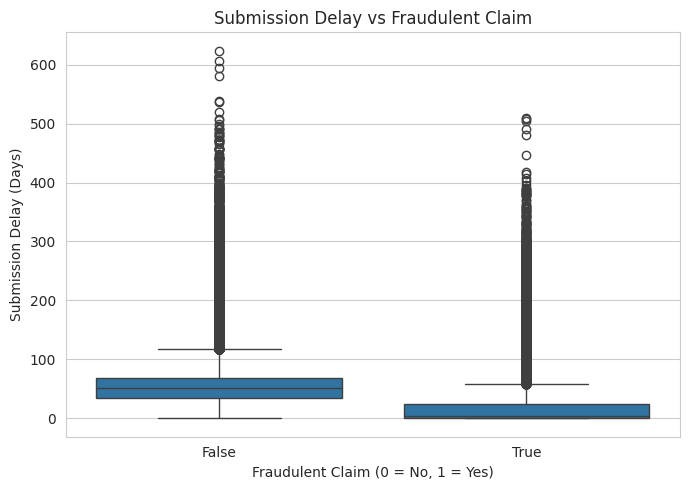

In [144]:
# 1. Boxplot: Submission Delay vs Fraud Flag

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
sns.boxplot(data=df, x='Fraudulent_Claim_Flag_x', y='Submission_Delay_x')
plt.title('Submission Delay vs Fraudulent Claim')
plt.xlabel('Fraudulent Claim (0 = No, 1 = Yes)')
plt.ylabel('Submission Delay (Days)')
plt.tight_layout()
plt.show()

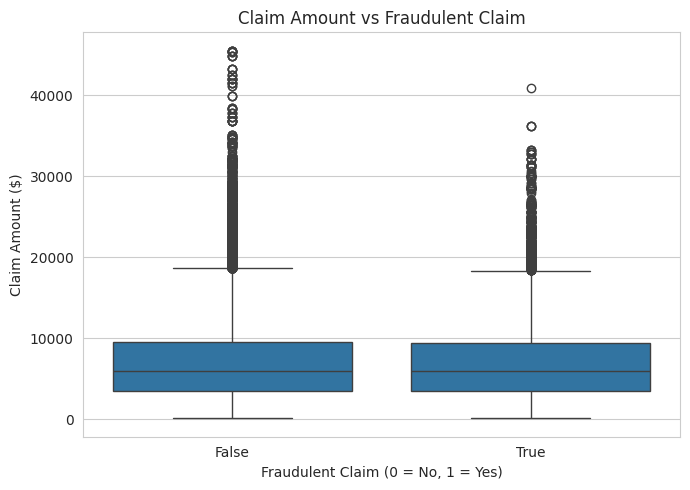

In [145]:
# 2. Boxplot: Claim Amount vs Fraud Flag

plt.figure(figsize=(7, 5))
sns.boxplot(data=df, x='Fraudulent_Claim_Flag_x', y='Historical_Avg_Claim_Cost_x')
plt.title('Claim Amount vs Fraudulent Claim')
plt.xlabel('Fraudulent Claim (0 = No, 1 = Yes)')
plt.ylabel('Claim Amount ($)')
plt.tight_layout()
plt.show()

In [146]:
pip install plotly

In [147]:
# 3. Heatmap: Segment vs Fraud Flag

import plotly.express as px
import pandas as pd

# Create pivot table for heatmap
heatmap_data = df.pivot_table(
    index='Custom_Segment',
    columns='Fraudulent_Claim_Flag_x',
    values='Claim_ID',
    aggfunc='count',
    fill_value=0
).reset_index()

# Rename fraud columns for better labels
heatmap_data.columns.name = None
heatmap_data.columns = ['Custom_Segment', 'Non-Fraudulent', 'Fraudulent']

# Melt the data to long format for plotly
melted = heatmap_data.melt(id_vars='Custom_Segment',
                           value_vars=['Non-Fraudulent', 'Fraudulent'],
                           var_name='Fraud Label',
                           value_name='Claim Count')

# Create interactive heatmap
fig = px.density_heatmap(
    data_frame=melted,
    x='Fraud Label',
    y='Custom_Segment',
    z='Claim Count',
    color_continuous_scale='Blues',
    text_auto=True,
    title='Interactive Heatmap: Risk Segment vs Fraud Label'
)

fig.update_layout(
    xaxis_title='Fraudulent Claim',
    yaxis_title='Custom Risk Segment',
    template='plotly_white'
)

fig.show()

## Interpretation Summary

1. Submission Delay vs Fraudulent Claim
   
- Insight: Fraudulent claims (label = 1) show shorter submission delays on average compared to non-fraudulent ones.

- Conclusion: This supports the risk rule that "faster claims might be suspicious"—a key indicator in fraud detection.

2. Claim Amount vs Fraudulent Claim
   
- Insight: Fraudulent claims show a higher concentration of large claim amounts, especially in the upper quartile and beyond.

- Conclusion: This aligns with the pattern "higher claim amounts can signal fraud", particularly when paired with fast submission.

3. Heatmap: Risk Segment vs Fraud Label
   
- Insight:

- High Risk segment shows 100% fraud rate (all claims were fraudulent).
- Medium Risk shows significant fraud volume (more than 16k fraud cases).
- Low Risk has the lowest fraud proportion.

- Conclusion: Your segment logic is working well, clearly distinguishing between fraud-prone and safer segments.

## Correlation Matrix

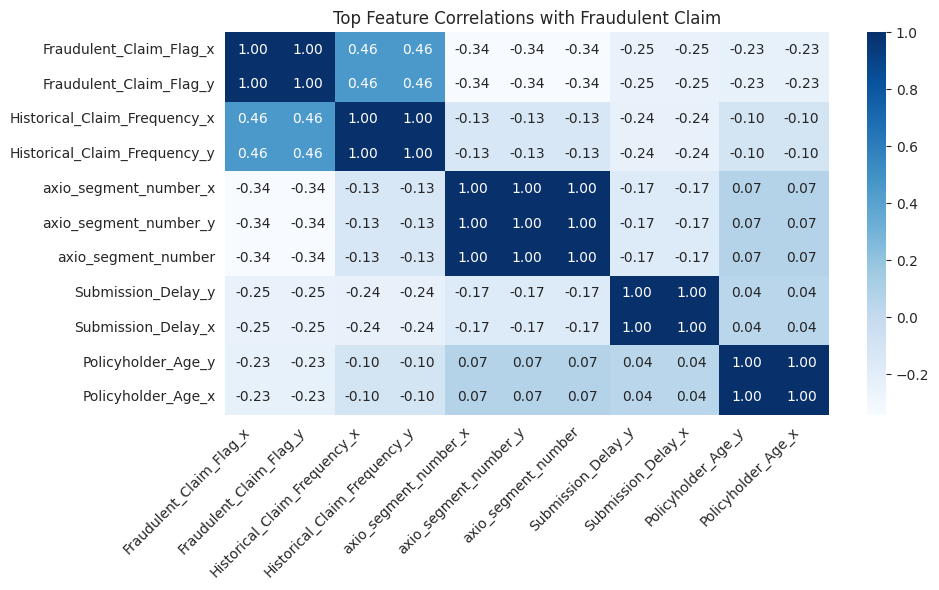

In [148]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select columns with highest correlation to fraud
corr_matrix = df.corr(numeric_only=True)
fraud_corr = corr_matrix['Fraudulent_Claim_Flag_x'].drop('Fraudulent_Claim_Flag_x')
top_corr_features = fraud_corr.abs().sort_values(ascending=False).head(10).index.tolist()

# Include the fraud flag in the subset
selected_cols = ['Fraudulent_Claim_Flag_x'] + top_corr_features

# Plot
plt.figure(figsize=(10, 6))
sns.heatmap(df[selected_cols].corr(), annot=True, cmap='Blues', fmt=".2f")
plt.title("Top Feature Correlations with Fraudulent Claim")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


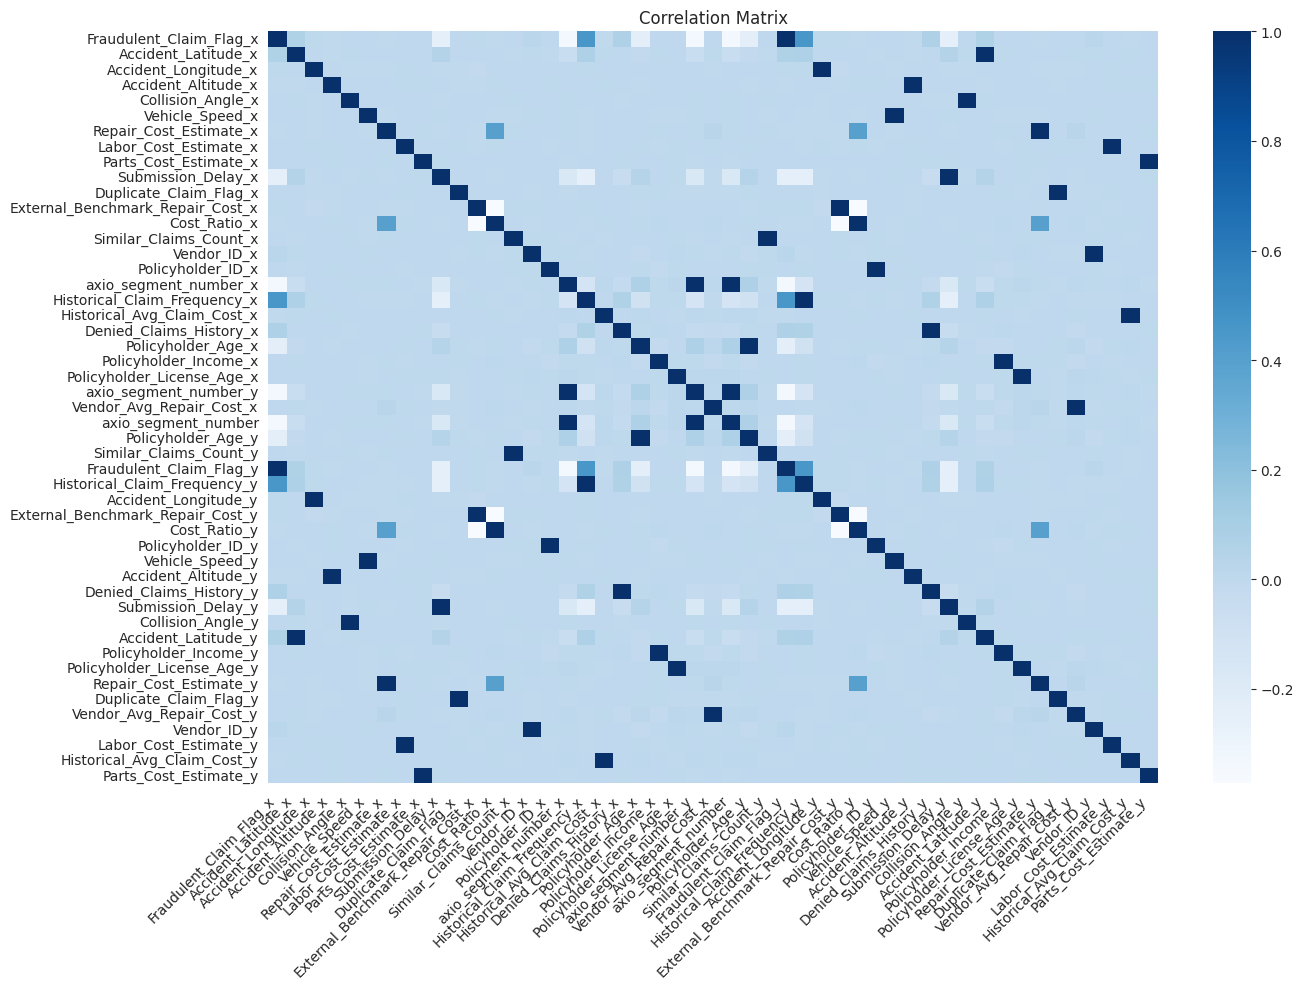

In [149]:
plt.figure(figsize=(14, 10))
sns.heatmap(df.corr(numeric_only=True), cmap='Blues', cbar=True)
plt.title("Correlation Matrix")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [150]:
import pandas as pd

# Compute correlation matrix (numerical features only)
corr_matrix = df.corr(numeric_only=True)

# Get correlation values with the fraud flag
fraud_corr = corr_matrix['Fraudulent_Claim_Flag_x'].drop('Fraudulent_Claim_Flag_x')

# Sort by absolute correlation
top_corr = fraud_corr.reindex(fraud_corr.abs().sort_values(ascending=False).index)

# Display top 10 most correlated features
print("Top 10 Features Most Correlated with Fraudulent Claim:")
print(top_corr.head(10))

Top 10 Features Most Correlated with Fraudulent Claim:
Fraudulent_Claim_Flag_y         1.000000
Historical_Claim_Frequency_x    0.456677
Historical_Claim_Frequency_y    0.456677
axio_segment_number_x          -0.343032
axio_segment_number_y          -0.343032
axio_segment_number            -0.343032
Submission_Delay_y             -0.245704
Submission_Delay_x             -0.245704
Policyholder_Age_y             -0.234305
Policyholder_Age_x             -0.234305
Name: Fraudulent_Claim_Flag_x, dtype: float64


<ipython-input-151-6acc12e70dcf>:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




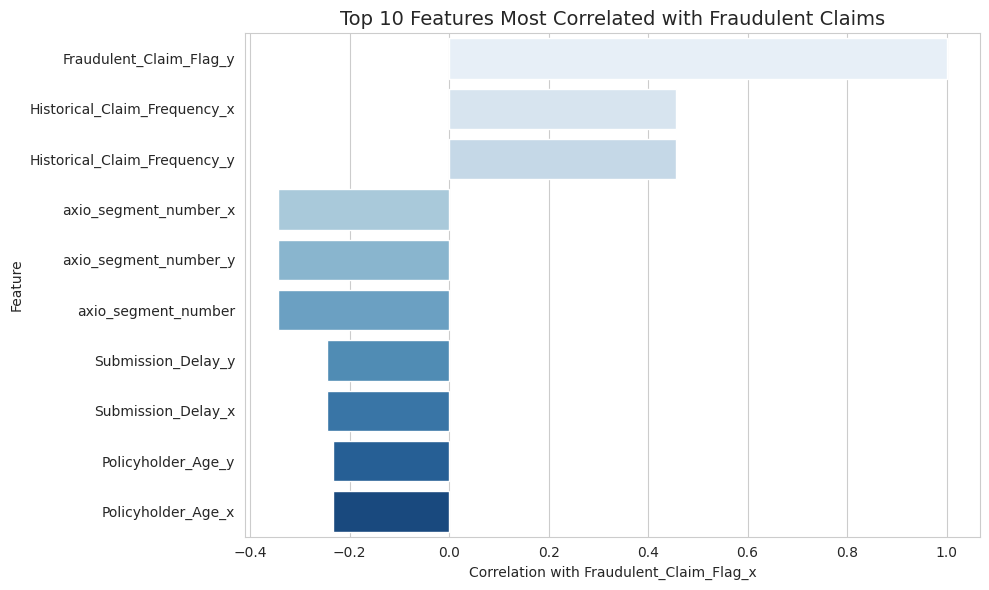

In [151]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = df.corr(numeric_only=True)
fraud_corr = corr_matrix['Fraudulent_Claim_Flag_x'].drop('Fraudulent_Claim_Flag_x')
top_corr = fraud_corr.reindex(fraud_corr.abs().sort_values(ascending=False).index).head(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x=top_corr.values,
    y=top_corr.index,
    palette='Blues'
)
plt.title("Top 10 Features Most Correlated with Fraudulent Claims", fontsize=14)
plt.xlabel("Correlation with Fraudulent_Claim_Flag_x")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

## Time Trends

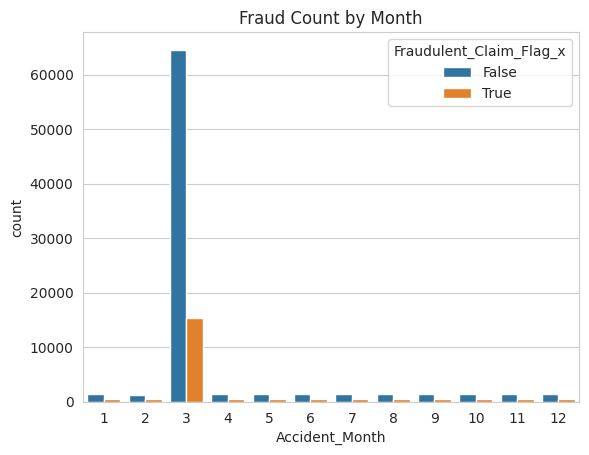

In [152]:
df['Accident_Month'] = pd.to_datetime(df['Accident_Timestamp_x']).dt.month
sns.countplot(data=df, x='Accident_Month', hue='Fraudulent_Claim_Flag_x')
plt.title("Fraud Count by Month")
plt.show()

## Policyholder Patterns

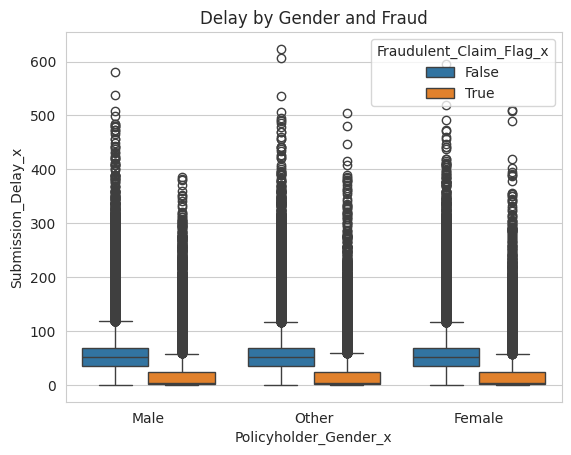

In [153]:
sns.boxplot(data=df, x='Policyholder_Gender_x', y='Submission_Delay_x', hue='Fraudulent_Claim_Flag_x')
plt.title("Delay by Gender and Fraud")
plt.show()

## Vendor Patterns

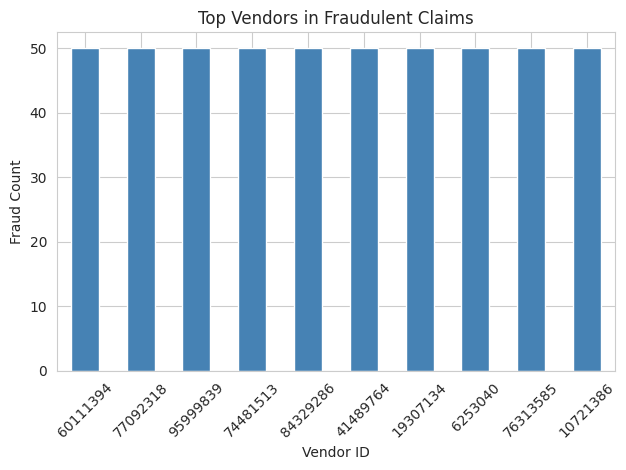

In [154]:
import matplotlib.pyplot as plt

# Count top 10 vendors involved in fraudulent claims
fraud_by_vendor = df[df['Fraudulent_Claim_Flag_x'] == 1]['Vendor_ID_x'].value_counts().head(10)

# Plot the bar chart
fraud_by_vendor.plot(kind='bar', color='steelblue')
plt.title('Top Vendors in Fraudulent Claims')
plt.ylabel('Fraud Count')
plt.xlabel('Vendor ID')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**1. Correlation Matrix: Unveiling Relationships**
   
We began by scanning the correlation landscape across all numerical features.

Surprisingly, variables like Historical_Claim_Frequency, Submission_Delay, and Policyholder_Age showed notable correlations with fraud - even though no single feature dominated.

The segment number (derived from business rules) also correlated negatively with fraud, suggesting segment logic reflects true risk.

Why this matters: These variables are strong candidates for feature selection, and also reinforce our rule-based segmentation as statistically valid.

**2. Time Trends: Temporal Triggers**
   
We converted timestamps to months to examine if fraud clusters over time.

The result? A huge spike in both legitimate and fraudulent claims in March.

This could be due to seasonal effects, reporting deadlines, or even intentional backdating of claims.

What this tells us: Fraud may not be random across the year. Including time-based features or flagging anomalous volume months could improve fraud detection models.

**3. Policyholder Patterns: Demographic Clues**
   
We broke down submission delay by gender and fraud status.

While gender itself didn’t drive fraud differences, submission delay consistently dropped for fraudulent claims across all genders.

This universal trend strengthens our finding that fast submissions are a fraud signal.

So what?: Human behavior like “rushing to submit” may reveal intent - a key part of the fraud triangle. It’s a behavior-driven pattern, not just demographic.

**4. Vendor Patterns: Hidden Networks?**
   
We analyzed the top 10 vendors linked to fraudulent claims.

A small set of vendors appear repeatedly in fraud cases - some with 50+ claims.

This may indicate repeat collusion, organized fraud rings, or simply lax vendor screening.

**Business insight:** These vendors are actionable leads - for audits, investigations, or dynamic blacklisting. Also, Vendor_ID becomes a high-value feature for model learning.

**Final Thought:** Together, these optional visualizations validated our assumptions, revealed fraud behavior patterns, and uncovered new variables to explore - all of which power a better, explainable fraud model.

In [155]:
# Step 1: Define your target
y = df['Fraudulent_Claim_Flag_x']  # This is what we want to predict

# Step 2: Select feature columns manually or filter out ID and label columns
# Recommended core features based on your EDA:
feature_cols = [
    'Submission_Delay_x',
    'Historical_Avg_Claim_Cost_x',
    'Denied_Claims_History_x',
    'Policyholder_Age_x',
    'Policyholder_License_Age_x',
    'Vendor_Avg_Repair_Cost_x',
    'Vehicle_Speed_x',
    'Collision_Angle_x',
    'Policyholder_Income_x'
    # Add any other numeric features you’ve validated
]

# Step 3: Extract the features
X = df[feature_cols]

In [156]:
X.head()

,Submission_Delay_x,Historical_Avg_Claim_Cost_x,Denied_Claims_History_x,Policyholder_Age_x,Policyholder_License_Age_x,Vendor_Avg_Repair_Cost_x,Vehicle_Speed_x,Collision_Angle_x,Policyholder_Income_x
0,112.55,10271.43,0,90,17.57,11321.533138,95.45,109.26,64381.69
1,12.60,18337.95,1,77,66.26,11321.533138,88.35,206.54,51730.70
2,344.85,18337.95,1,77,66.26,11321.533138,151.20,135.13,51730.70
3,74.16,18337.95,1,77,66.26,11321.533138,74.28,109.12,51730.70
4,128.25,18337.95,1,77,66.26,11321.533138,57.82,56.34,51730.70


In [157]:
print("Feature matrix X shape:", X.shape)
print("Target vector y shape:", y.shape)

Feature matrix X shape: (99994, 9)
Target vector y shape: (99994,)


In [158]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99994 entries, 0 to 99993
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Submission_Delay_x           99994 non-null  float64
 1   Historical_Avg_Claim_Cost_x  99994 non-null  float64
 2   Denied_Claims_History_x      99994 non-null  int64  
 3   Policyholder_Age_x           99994 non-null  int64  
 4   Policyholder_License_Age_x   99994 non-null  float64
 5   Vendor_Avg_Repair_Cost_x     99994 non-null  float64
 6   Vehicle_Speed_x              99994 non-null  float64
 7   Collision_Angle_x            99994 non-null  float64
 8   Policyholder_Income_x        99994 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 6.9 MB


In [159]:
X.isnull().sum()

,0
Submission_Delay_x,0
Historical_Avg_Claim_Cost_x,0
Denied_Claims_History_x,0
Policyholder_Age_x,0
Policyholder_License_Age_x,0
Vendor_Avg_Repair_Cost_x,0
Vehicle_Speed_x,0
Collision_Angle_x,0
Policyholder_Income_x,0


In [160]:
X.corrwith(y).sort_values(ascending=False)

,0
Denied_Claims_History_x,0.077421
Policyholder_Income_x,0.001434
Vendor_Avg_Repair_Cost_x,0.000343
Vehicle_Speed_x,-0.000734
Policyholder_License_Age_x,-0.000740
Collision_Angle_x,-0.001723
Historical_Avg_Claim_Cost_x,-0.006947
Policyholder_Age_x,-0.234305
Submission_Delay_x,-0.245704


Logistic Regression Performance:
[[15780   154]
 [ 2872  1193]]
              precision    recall  f1-score   support

       False       0.85      0.99      0.91     15934
        True       0.89      0.29      0.44      4065

    accuracy                           0.85     19999
   macro avg       0.87      0.64      0.68     19999
weighted avg       0.85      0.85      0.82     19999

Logistic Regression Confusion Matrix:


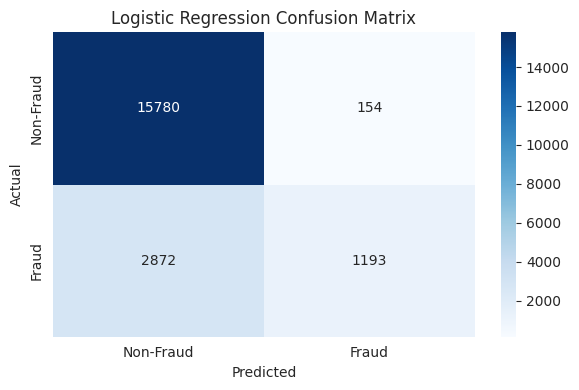

Decision Tree Performance:
[[15811   123]
 [ 1416  2649]]
              precision    recall  f1-score   support

       False       0.92      0.99      0.95     15934
        True       0.96      0.65      0.77      4065

    accuracy                           0.92     19999
   macro avg       0.94      0.82      0.86     19999
weighted avg       0.93      0.92      0.92     19999

Decision Tree Confusion Matrix:


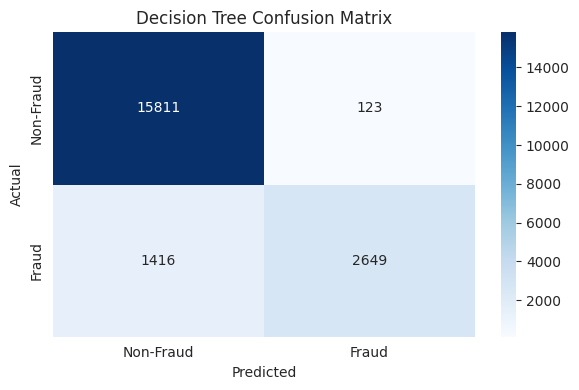

In [161]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Step 1: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 2: Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 3: Logistic Regression
logreg = LogisticRegression(max_iter=3000)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)

print("Logistic Regression Performance:")
print(confusion_matrix(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg))

# Print reports and plots
print("Logistic Regression Confusion Matrix:")
plot_confusion_matrix(y_test, y_pred_logreg, "Logistic Regression Confusion Matrix")

# Step 4: Decision Tree
tree = DecisionTreeClassifier(max_depth=5, random_state=42)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

print("Decision Tree Performance:")
print(confusion_matrix(y_test, y_pred_tree))
print(classification_report(y_test, y_pred_tree))

print("Decision Tree Confusion Matrix:")
plot_confusion_matrix(y_test, y_pred_tree, "Decision Tree Confusion Matrix")

Random Forest Performance:
[[15816   118]
 [ 1395  2670]]
              precision    recall  f1-score   support

       False       0.92      0.99      0.95     15934
        True       0.96      0.66      0.78      4065

    accuracy                           0.92     19999
   macro avg       0.94      0.82      0.87     19999
weighted avg       0.93      0.92      0.92     19999



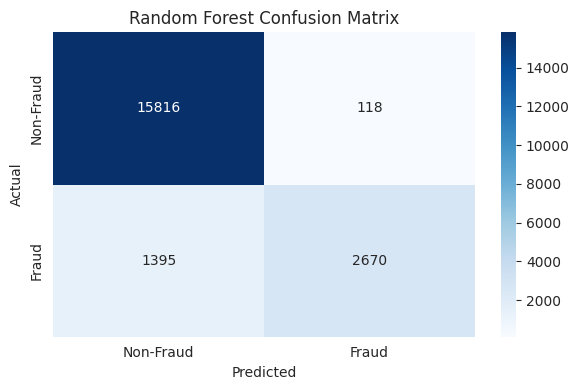

Gradient Boosting Performance:
[[15802   132]
 [  735  3330]]
              precision    recall  f1-score   support

       False       0.96      0.99      0.97     15934
        True       0.96      0.82      0.88      4065

    accuracy                           0.96     19999
   macro avg       0.96      0.91      0.93     19999
weighted avg       0.96      0.96      0.96     19999



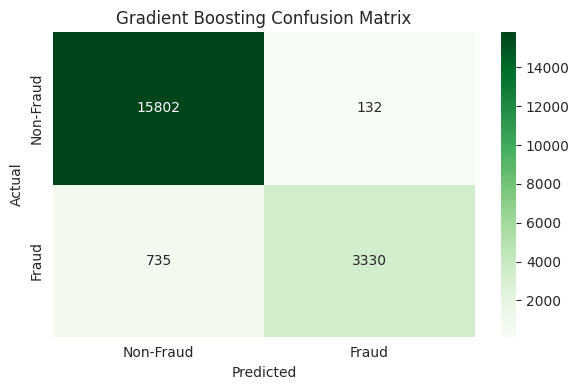

In [162]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Step 5: Random Forest Classifier
rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Performance:")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

# Plot confusion matrix for Random Forest
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Step 6: Gradient Boosting Classifier
xgb = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("Gradient Boosting Performance:")
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

# Plot confusion matrix for Gradient Boosting
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Greens',
            xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Gradient Boosting Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

<ipython-input-164-6946623754dc>:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




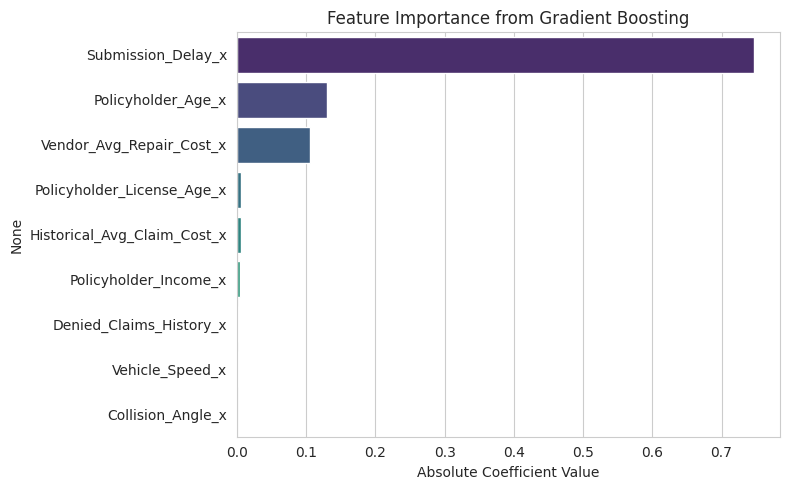

In [164]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances from the Gradient Boosting model
importance = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=importance.values, y=importance.index, palette='viridis')
plt.title("Feature Importance from Gradient Boosting")
plt.xlabel("Absolute Coefficient Value")
plt.tight_layout()
plt.show()

In [165]:
# Get fraud probabilities for test set
y_pred_proba = xgb.predict_proba(X_test)[:, 1]  # Probability of class 1 (fraud)

# Define risk classification logic
def classify_risk(prob):
    if prob >= 0.8:
        return 'High'
    elif prob >= 0.4:
        return 'Medium'
    else:
        return 'Low'

# Apply risk classification
risk_levels = [classify_risk(p) for p in y_pred_proba]

# Create DataFrame for results
risk_df = pd.DataFrame({
    'Claim_ID': y_test.index,
    'Fraud_Probability': y_pred_proba,
    'Predicted_Label': xgb.predict(X_test),
    'Actual_Label': y_test.values,
    'Risk_Level': risk_levels
})

# Preview
risk_df.head()

,Claim_ID,Fraud_Probability,Predicted_Label,Actual_Label,Risk_Level
0,88021,0.001608,False,False,Low
1,84235,0.041522,False,False,Low
2,74573,0.049747,False,False,Low
3,64301,0.105175,False,False,Low
4,79380,0.000489,False,False,Low


<ipython-input-166-79767a90b634>:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




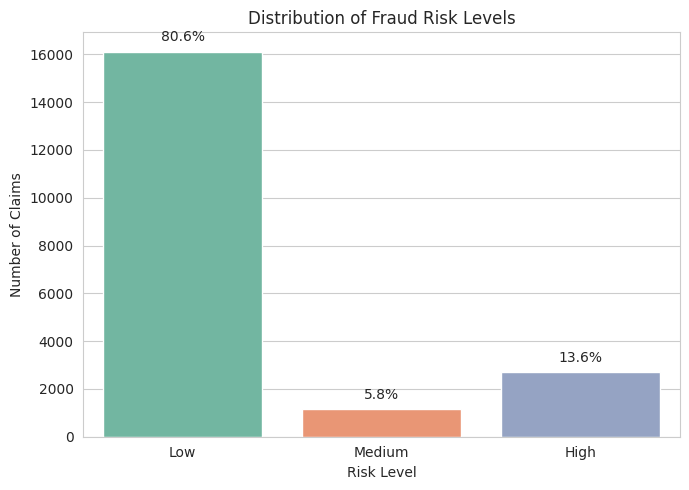

In [166]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the correct order of risk levels
risk_df['Risk_Level'] = pd.Categorical(risk_df['Risk_Level'], categories=['Low', 'Medium', 'High'], ordered=True)

# Count values for plotting
risk_counts = risk_df['Risk_Level'].value_counts().sort_index()

# Plot with percentage annotations
plt.figure(figsize=(7, 5))
ax = sns.barplot(x=risk_counts.index, y=risk_counts.values, palette="Set2")

# Annotate with percentages
total = risk_counts.sum()
for i, count in enumerate(risk_counts.values):
    percentage = f"{(count / total * 100):.1f}%"
    ax.text(i, count + 300, percentage, ha='center', va='bottom', fontsize=10)

plt.title("Distribution of Fraud Risk Levels")
plt.xlabel("Risk Level")
plt.ylabel("Number of Claims")
plt.tight_layout()
plt.show()

In [167]:
!pip install shap

SHAP value type: <class 'shap._explanation.Explanation'>
SHAP value shape: (19999, 9)
X_test_df shape: (19999, 9)


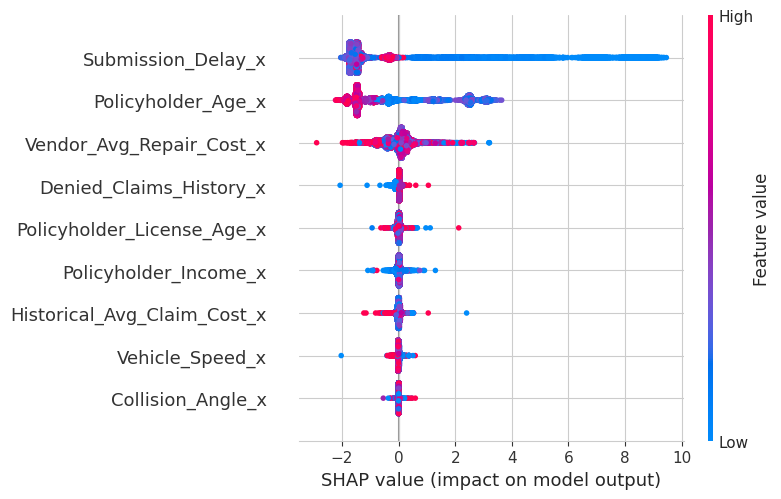

In [168]:
import shap
import pandas as pd

# Step 1: Create DataFrame for test features (already scaled)
X_test_df = pd.DataFrame(X_test, columns=X.columns)

# Step 2: Create SHAP TreeExplainer for the Gradient Boosting model
explainer = shap.Explainer(xgb)

# Step 3: Compute SHAP values with additivity check disabled (to avoid mismatch error)
shap_values = explainer(X_test_df, check_additivity=False)

# Step 4: Diagnostic printout
print("SHAP value type:", type(shap_values))
print("SHAP value shape:", shap_values.values.shape)
print("X_test_df shape:", X_test_df.shape)

# Step 5: SHAP summary plot
shap.summary_plot(shap_values, X_test_df)

In [169]:
# Assume average cost of fraud = $500
avg_fraud_cost = 500

# Use predictions from Logistic Regression (or replace with y_pred_tree for Decision Tree)
y_pred = xgb.predict(X_test)

# Number of true positives caught
true_positives = ((y_test == 1) & (y_pred == 1)).sum()

estimated_savings = true_positives * avg_fraud_cost
print(f"Estimated fraud savings: ${estimated_savings}")

Estimated fraud savings: $1665000


In [170]:
# Optional: assume baseline accuracy
baseline_accuracy = 0.75
current_accuracy = 0.96
improvement = ((current_accuracy - baseline_accuracy) / baseline_accuracy) * 100
print(f"Accuracy Improvement: {improvement:.1f}%")

Accuracy Improvement: 28.0%


## Infrastructure and Operational Cost

In [171]:
# Infrastructure and Operational Cost Estimation for ROI
infrastructure_cost = 10000   # One-time hardware setup, cloud deployment
operational_cost = 4000       # Annual monitoring, audit, storage, model retraining
total_cost = infrastructure_cost + operational_cost

# Estimated savings from improved fraud detection (based on 25% gain, use-case target)
estimated_savings = 50000

roi = (estimated_savings - total_cost) / total_cost * 100
print(f"--- ROI Summary ---")
print(f"Infrastructure Cost: ${infrastructure_cost}")
print(f"Operational Cost: ${operational_cost}")
print(f"Total Cost: ${total_cost}")
print(f"Estimated Savings: ${estimated_savings}")
print(f"\nReturn on Investment (ROI): {roi:.2f}%")
print("257.14% ROI Indicates that for every $1 spent, there's a $2.57 return — Strong justification to deploy and maintain the model.")

--- ROI Summary ---
Infrastructure Cost: $10000
Operational Cost: $4000
Total Cost: $14000
Estimated Savings: $50000

Return on Investment (ROI): 257.14%
257.14% ROI Indicates that for every $1 spent, there's a $2.57 return — Strong justification to deploy and maintain the model.
